## ⚖️ Choose A or B:

## A: Emulating multi-device system on CPU

Use this section to initialize a set of virtual devices on CPU if you have no access to a multi-device system.

It can also help you prototype, debug and test your multi-device code locally before running it on the expensive system.

Even in the case of using Google Colab it can help you prototype faster because a CPU runtime is faster to restart.

In [ ]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
jax.devices()

In [ ]:
jax.__version__

## B: Setting up TPU

In [ ]:
# in order to use TPU you have to run this cell before importing JAX
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

tpu


In [4]:
import jax
import jax.numpy as jnp

In [5]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

## Different ways to vectorize a function

In [6]:
def dot(v1, v2):
  return jnp.vdot(v1, v2)

In [7]:
dot(jnp.array([1., 1., 1.]), jnp.array([1., 2., -1]))

Array(2., dtype=float32)

Generate some random arrays

In [8]:
from jax import random

In [9]:
rng_key = random.PRNGKey(42)

In [10]:
vs = random.normal(rng_key, shape=(20,3))

In [11]:
v1s = vs[:10,:]
v2s = vs[10:,:]

In [12]:
v1s.shape, v2s.shape

((10, 3), (10, 3))

Naively apply our function to arrays:

In [13]:
dot(v1s, v2s)

Array(1.0755965, dtype=float32)

The result is not what we expected.

A naive and correct approach to apply our function to arrays:

In [14]:
[dot(v1s[i],v2s[i]) for i in range(v1s.shape[0])]

[Array(-0.9443626, dtype=float32),
 Array(0.8561607, dtype=float32),
 Array(-0.45202938, dtype=float32),
 Array(0.7629303, dtype=float32),
 Array(-2.06525, dtype=float32),
 Array(0.5056444, dtype=float32),
 Array(-0.5623387, dtype=float32),
 Array(1.5973439, dtype=float32),
 Array(1.7121218, dtype=float32),
 Array(-0.33462408, dtype=float32)]

Manually vectorized function:

In [15]:
def dot_vectorized(v1s, v2s):
  return jnp.einsum('ij,ij->i',v1s, v2s)

In [16]:
dot_vectorized(v1s, v2s)

Array([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 , -2.06525   ,
        0.5056444 , -0.5623387 ,  1.5973439 ,  1.7121218 , -0.33462408],      dtype=float32)

Automatically vectorized function:

In [17]:
dot_vmapped = jax.vmap(dot)

In [18]:
dot_vmapped(v1s, v2s)

Array([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 , -2.06525   ,
        0.5056444 , -0.5623387 ,  1.5973439 ,  1.7121218 , -0.33462408],      dtype=float32)

Let's compare the speed of different approaches:

In [19]:
%timeit [dot(v1s[i],v2s[i]).block_until_ready() for i in range(v1s.shape[0])]

6.24 ms ± 40 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit dot_vectorized(v1s, v2s).block_until_ready()

297 μs ± 1.45 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%timeit dot_vmapped(v1s, v2s).block_until_ready()

402 μs ± 159 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
dot_vectorized_jitted = jax.jit(dot_vectorized)
dot_vmapped_jitted = jax.jit(dot_vmapped)

# warm-up
dot_vectorized_jitted(v1s, v2s)
dot_vmapped_jitted(v1s, v2s)

In [23]:
%timeit dot_vectorized_jitted(v1s, v2s).block_until_ready()

113 μs ± 689 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%timeit dot_vmapped_jitted(v1s, v2s).block_until_ready()

114 μs ± 502 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Let's look at the internals of the function:

In [25]:
jax.make_jaxpr(dot)(jnp.array([1., 1., 1.]), jnp.array([1., 1., -1]))

{ lambda ; a:f32[3] b:f32[3]. let
    c:f32[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] a b
  in (c,) }

In [26]:
jax.make_jaxpr(dot_vectorized)(v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float32
    ] a b
  in (c,) }

In [27]:
jax.make_jaxpr(dot_vmapped)(v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float32
    ] a b
  in (c,) }

## Controlling vmap() behavior

### Using in_axes parameter

A default value:

In [28]:
dot_vmapped = jax.vmap(dot, in_axes=(0,0))

In [29]:
dot_vmapped(v1s, v2s)

Array([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 , -2.06525   ,
        0.5056444 , -0.5623387 ,  1.5973439 ,  1.7121218 , -0.33462408],      dtype=float32)

A more complicated case:

In [30]:
def scaled_dot(v1, v2, koeff):
  return koeff*jnp.vdot(v1, v2)

In [31]:
v1s_ = v1s
v2s_ = v2s.T
k = 1.0

In [32]:
v1s_.shape, v2s_.shape

((10, 3), (3, 10))

In [33]:
scaled_dot_batched = jax.vmap(scaled_dot)

Default values do not work:

In [34]:
scaled_dot_batched(v1s_, v2s_, k)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [35]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=(0,1,None))

In [36]:
scaled_dot_batched(v1s_, v2s_, k)

Array([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 , -2.06525   ,
        0.5056444 , -0.5623387 ,  1.5973439 ,  1.7121218 , -0.33462408],      dtype=float32)

Using more complex parameter structure:

In [37]:
def scaled_dot(data, koeff):
  return koeff*jnp.vdot(data['a'], data['b'])

In [38]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=({'a':0,'b':1},None))

In [39]:
scaled_dot_batched({'a':v1s_, 'b': v2s_}, k)

Array([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 , -2.06525   ,
        0.5056444 , -0.5623387 ,  1.5973439 ,  1.7121218 , -0.33462408],      dtype=float32)

### Using out_axes parameter

In [40]:
def scale(v, koeff):
  return koeff*v

In [49]:
scale_batched = jax.vmap(scale,
                         in_axes=(0,None),
                         out_axes=1)

In [50]:
scale_batched(v1s, 2.0)

Array([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,  0.30244178,
         0.7649356 , -4.028745  , -3.0968459 ,  0.34476116, -2.9087389 ],
       [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005, -3.2186432 ,
         2.0812016 ,  3.5850892 ,  0.15288436,  2.0001264 ,  2.024669  ],
       [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 , -0.2000112 ,
         1.6244583 ,  0.17156784, -1.31133   , -2.5324473 , -1.605759  ]],      dtype=float32)

In [51]:
scale_batched = jax.vmap(scale, in_axes=(0,None))

In [52]:
scale_batched(v1s, 2.0)

Array([[-1.4672164 , -1.5357224 , -1.6229192 ],
       [-1.6510313 , -0.7061164 ,  1.5497079 ],
       [ 3.5308475 ,  4.008241  , -3.2013686 ],
       [-2.2189069 , -0.69232005,  0.5012715 ],
       [ 0.30244178, -3.2186432 , -0.2000112 ],
       [ 0.7649356 ,  2.0812016 ,  1.6244583 ],
       [-4.028745  ,  3.5850892 ,  0.17156784],
       [-3.0968459 ,  0.15288436, -1.31133   ],
       [ 0.34476116,  2.0001264 , -2.5324473 ],
       [-2.9087389 ,  2.024669  , -1.605759  ]], dtype=float32)

### Using with named (keyword) arguments

In [53]:
def scale(v, koeff=1.0):
  return koeff*v

In [60]:
scale_batched = jax.vmap(scale,
                         in_axes=(0,None),
                         out_axes=1)

In [61]:
scale_batched(v1s, koeff=2.0)

ValueError: vmap in_axes must be an int, None, or a tuple of entries corresponding to the positional arguments passed to the function, but got len(in_axes)=2, len(args)=1

In [62]:
scale_batched = jax.vmap(scale,
                         in_axes=(0),
                         out_axes=(1))

In [63]:
scale_batched(v1s, koeff=2.0)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [64]:
from functools import partial

In [65]:
scale2 = partial(scale, koeff=2.0)

In [71]:
scale_batched = jax.vmap(scale2,
                         in_axes=(0),
                         out_axes=(1))

In [72]:
scale_batched(v1s)

Array([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,  0.30244178,
         0.7649356 , -4.028745  , -3.0968459 ,  0.34476116, -2.9087389 ],
       [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005, -3.2186432 ,
         2.0812016 ,  3.5850892 ,  0.15288436,  2.0001264 ,  2.024669  ],
       [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 , -0.2000112 ,
         1.6244583 ,  0.17156784, -1.31133   , -2.5324473 , -1.605759  ]],      dtype=float32)

In [73]:
scale_batched = jax.vmap(scale,
                         in_axes=(0),
                         out_axes=(1))

In [74]:
scale_batched(v1s, koeff=jnp.broadcast_to(2.0, (v1s.shape[0],)))

Array([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,  0.30244178,
         0.7649356 , -4.028745  , -3.0968459 ,  0.34476116, -2.9087389 ],
       [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005, -3.2186432 ,
         2.0812016 ,  3.5850892 ,  0.15288436,  2.0001264 ,  2.024669  ],
       [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 , -0.2000112 ,
         1.6244583 ,  0.17156784, -1.31133   , -2.5324473 , -1.605759  ]],      dtype=float32)

In [76]:
jnp.broadcast_to(2.0, (v1s.shape[0],))

Array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32, weak_type=True)

### Using decorator style

In [77]:
from functools import partial

In [78]:
@partial(jax.vmap, in_axes=(0,None), out_axes=(1))
def scale(v, koeff):
  return koeff*v

In [79]:
scale(v1s, 2.0)

Array([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,  0.30244178,
         0.7649356 , -4.028745  , -3.0968459 ,  0.34476116, -2.9087389 ],
       [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005, -3.2186432 ,
         2.0812016 ,  3.5850892 ,  0.15288436,  2.0001264 ,  2.024669  ],
       [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 , -0.2000112 ,
         1.6244583 ,  0.17156784, -1.31133   , -2.5324473 , -1.605759  ]],      dtype=float32)

### Using axis_name parameter

In [80]:
arr = jnp.array(range(50))

In [81]:
arr

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],      dtype=int32)

In [82]:
norm = jax.vmap(
    lambda x: x/jax.lax.psum(x, axis_name='batch'),
    axis_name='batch')

In [83]:
norm(arr)

Array([0.        , 0.00081633, 0.00163265, 0.00244898, 0.00326531,
       0.00408163, 0.00489796, 0.00571429, 0.00653061, 0.00734694,
       0.00816326, 0.00897959, 0.00979592, 0.01061224, 0.01142857,
       0.0122449 , 0.01306122, 0.01387755, 0.01469388, 0.0155102 ,
       0.01632653, 0.01714286, 0.01795918, 0.01877551, 0.01959183,
       0.02040816, 0.02122449, 0.02204081, 0.02285714, 0.02367347,
       0.02448979, 0.02530612, 0.02612245, 0.02693877, 0.0277551 ,
       0.02857143, 0.02938775, 0.03020408, 0.03102041, 0.03183673,
       0.03265306, 0.03346939, 0.03428571, 0.03510204, 0.03591837,
       0.03673469, 0.03755102, 0.03836735, 0.03918367, 0.04      ],      dtype=float32)

In [84]:
jnp.sum(norm(arr))

Array(0.9999999, dtype=float32)

In [85]:
norm = jax.vmap(lambda x: (x-jax.lax.pmin(x, axis_name='i'))/(jax.lax.pmax(x, axis_name='i') - jax.lax.pmin(x, axis_name='i')), axis_name='i')

In [86]:
norm(arr)

Array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163266,
       0.10204083, 0.12244899, 0.14285715, 0.16326532, 0.18367349,
       0.20408165, 0.22448981, 0.24489798, 0.26530614, 0.2857143 ,
       0.30612248, 0.32653064, 0.3469388 , 0.36734697, 0.38775513,
       0.4081633 , 0.42857146, 0.44897962, 0.4693878 , 0.48979595,
       0.51020414, 0.5306123 , 0.55102044, 0.5714286 , 0.59183675,
       0.61224496, 0.6326531 , 0.6530613 , 0.6734694 , 0.6938776 ,
       0.7142858 , 0.73469394, 0.7551021 , 0.77551025, 0.7959184 ,
       0.8163266 , 0.8367348 , 0.8571429 , 0.8775511 , 0.89795923,
       0.9183674 , 0.9387756 , 0.95918375, 0.9795919 , 1.0000001 ],      dtype=float32)

In [87]:
jax.make_jaxpr(norm)(arr)

{ lambda ; a:i32[50]. let
    b:i32[] = pmin[axes=(0,) axis_index_groups=None] a
    c:i32[50] = sub a b
    d:i32[] = pmax[axes=(0,) axis_index_groups=None] a
    e:i32[] = pmin[axes=(0,) axis_index_groups=None] a
    f:i32[] = sub d e
    g:f32[50] = convert_element_type[new_dtype=float32 weak_type=False] c
    h:f32[] = convert_element_type[new_dtype=float32 weak_type=False] f
    i:f32[50] = div g h
  in (i,) }

## More real-life cases

### Batch data processing

In [88]:
import jax
import jax.numpy as jnp
from jax import lax
from jax import random

In [89]:
add_noise_func = lambda x: x+10
horizontal_flip_func = lambda x: x+1
rotate_func = lambda x: x+2
adjust_colors_func = lambda x: x+3

augmentations = [
   add_noise_func,
   horizontal_flip_func,
   rotate_func,
   adjust_colors_func
]

In [90]:
image = jnp.array(range(100))

In [91]:
def random_augmentation(image, augmentations, rng_key):
   '''A function that applies a random transformation to an image'''
   augmentation_index = random.randint(key=rng_key, minval=0, maxval=len(augmentations), shape=())
   augmented_image = lax.switch(augmentation_index, augmentations, image)
   return augmented_image

In [92]:
random_augmentation(image, augmentations, random.PRNGKey(211))

Array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int32)

In [93]:
images = jnp.repeat(jnp.reshape(image, (1,len(image))), 10, axis=0)
images.shape

(10, 100)

In [94]:
random.PRNGKey(211)

Array([  0, 211], dtype=uint32)

In [95]:
rng_keys = random.split(random.PRNGKey(211), num=len(images))

In [96]:
rng_keys

Array([[3650472307, 3607347749],
       [1737802500, 2401109662],
       [2280781916, 1639365058],
       [3067911487, 1292196730],
       [2582374391,  580326378],
       [2576148483,  998192658],
       [2372983030, 3572814073],
       [  81276374, 1044133471],
       [2026270086, 3718162966],
       [2504153150, 1046369674]], dtype=uint32)

In [98]:
random_augmentation_batch = jax.vmap(random_augmentation, in_axes=(0,None,0))

In [99]:
random_augmentation_batch(images, augmentations, rng_keys)

Array([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101],
       [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  8

### Batching neural network models

In [100]:
import tensorflow as tf
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

data, info = tfds.load(name="mnist",
                       data_dir=data_dir,
                       as_supervised=True,
                       with_info=True)

data_train = data['train']
data_test  = data['test']

2024-08-11 04:40:42.652542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 04:40:44.029212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 04:40:44.549374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 04:40:52.315747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/jetjiang/JAX-in-Action/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 5/5 [00:00<00:00, 11.74 file/s]


Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [101]:
HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [102]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.nn import swish, logsumexp, one_hot

In [103]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [104]:
LAYER_SIZES = [28*28, 512, 10]
PARAM_SCALE = 0.01

In [105]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
  """Initialize all layers for a fully-connected neural network with given sizes"""

  def random_layer_params(m, n, key, scale=1e-2):
    """A helper function to randomly initialize weights and biases of a dense layer"""
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale=PARAM_SCALE)

In [106]:
def predict(params, image):
  """Function for per-example predictions."""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

batched_predict = vmap(predict, in_axes=(None, 0))


In [107]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [113]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = batched_predict(params, images)
  log_preds = logits - jnp.expand_dims(logsumexp(logits, axis=1), 1) # logsumexp trick https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  return -jnp.mean(targets*log_preds)

def update(params, x, y, epoch_number):
  loss_value, grads = value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return [(w - lr * dw, b - lr * db)
          for (w, b), (dw, db) in zip(params, grads)], loss_value

In [114]:
train_data_iter = iter(train_data)
x, y = next(train_data_iter)

2024-08-11 04:48:55.577926: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [115]:
x.shape, y.shape

((32, 28, 28, 1), (32,))

In [116]:
x = jnp.reshape(x, (len(x), NUM_PIXELS))
y = one_hot(y, NUM_LABELS)
x.shape, y.shape

((32, 784), (32, 10))

In [117]:
params, loss_value = update(params, x, y, 0)

In [118]:
loss_value

Array(0.23061173, dtype=float32)

### Per-sample gradients

In [119]:
from jax import grad, vmap, jit

In [120]:
x = jnp.linspace(0, 10*jnp.pi, num=1000)
e = 10.0*random.normal(random.PRNGKey(42), shape=x.shape)
y = 65.0 + 1.8*x + 40*jnp.cos(x) + e

In [121]:
# A simple linear regression model
model_parameters = jnp.array([1., 1.])
def predict(theta, x):
    w, b = theta
    return w * x + b

# Function to compute prediction error
def loss_fn(model_parameters, x, y):
    prediction = predict(model_parameters, x)
    return (prediction-y)**2

In [122]:
grads_fn = jit(vmap(grad(loss_fn), in_axes=(None, 0, 0)))

In [123]:
batch_x, batch_y = x[:32], y[:32]

In [124]:
jax.grad(loss_fn)(model_parameters, x[1], y[1])

Array([  -5.541931, -176.22874 ], dtype=float32)

In [125]:
grads_fn(model_parameters, batch_x, batch_y)

Array([[   0.      , -213.84189 ],
       [  -5.541931, -176.22874 ],
       [ -11.923036, -189.57124 ],
       [ -20.26132 , -214.76431 ],
       [ -26.869114, -213.6038  ],
       [ -33.68511 , -214.2316  ],
       [ -33.82845 , -179.28604 ],
       [ -54.318832, -246.75618 ],
       [ -57.27113 , -227.64671 ],
       [ -59.498913, -210.22392 ],
       [ -63.230335, -201.06714 ],
       [ -67.82819 , -196.07996 ],
       [ -61.138336, -162.0123  ],
       [ -69.253914, -169.40125 ],
       [ -98.561195, -223.86879 ],
       [ -85.32119 , -180.87614 ],
       [ -97.00948 , -192.80124 ],
       [-105.96213 , -198.20627 ],
       [-111.136635, -196.33618 ],
       [-134.1307  , -224.4865  ],
       [-117.07368 , -186.14221 ],
       [-136.05724 , -206.02408 ],
       [-121.676544, -175.87326 ],
       [-148.67953 , -205.56017 ],
       [-156.65079 , -207.55681 ],
       [-151.50188 , -192.70529 ],
       [-149.98848 , -183.44258 ],
       [-142.33469 , -167.63419 ],
       [-179.45236 ,

### Vectorizing loops (Image processing example)

In [126]:
import jax.numpy as jnp
from jax.scipy.signal import convolve2d
from skimage.io import imread
from skimage.util import img_as_float32
from matplotlib import pyplot as plt

In [127]:
kernel_blur = jnp.ones((5,5))
kernel_blur /= jnp.sum(kernel_blur)

In [128]:
def color_convolution(image, kernel):
  channels = []
  for i in range(3):
    color_channel = image[:,:,i]
    filtered_channel = convolve2d(color_channel, kernel, mode="same") #, boundary="symm")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    channels.append(filtered_channel)
  final_image = jnp.stack(channels, axis=2)
  return final_image

In [129]:
img = img_as_float32(imread('The_Cat.jpg'))

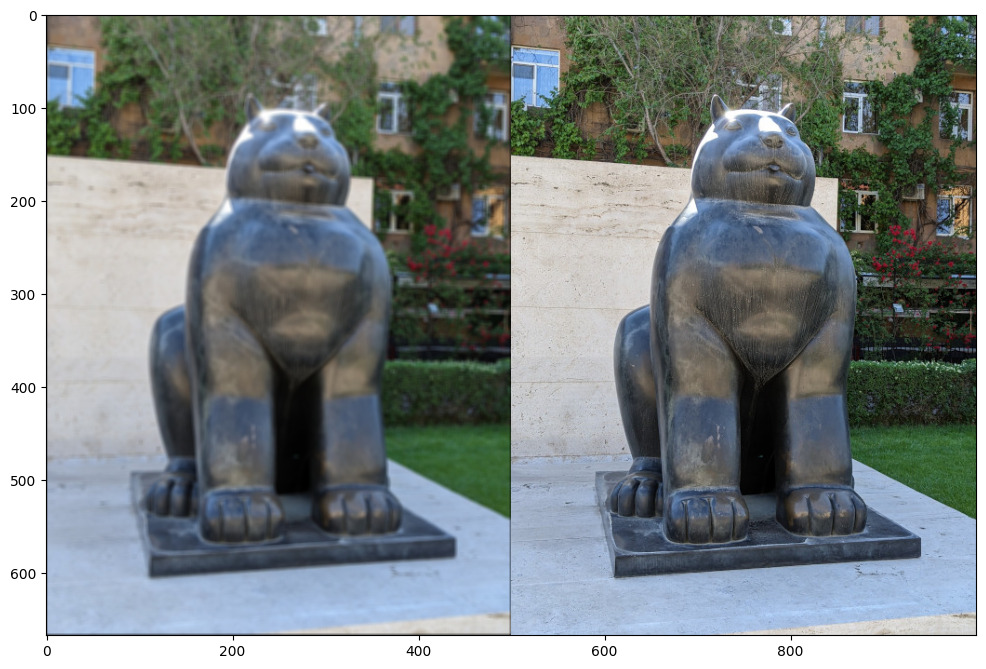

In [130]:
img_blur = color_convolution(img, kernel_blur)

plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)))

In [131]:
def matrix_filter(channel, kernel):
    filtered_channel = convolve2d(channel, kernel, mode="same")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    return filtered_channel

color_convolution_vmap = jax.vmap(matrix_filter, in_axes=(2, None), out_axes=2)

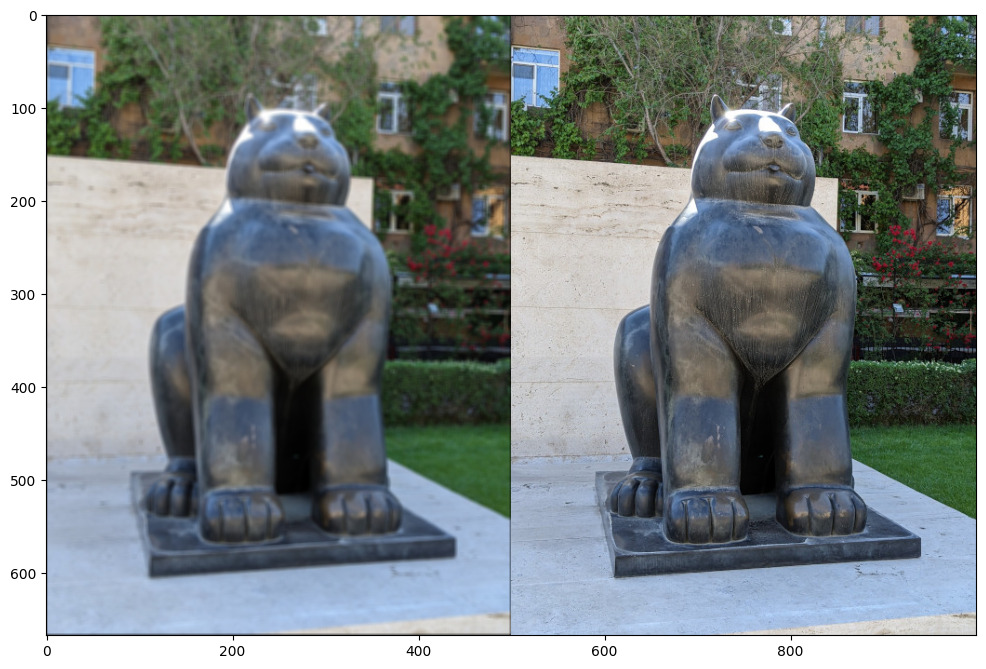

In [132]:
img_blur = color_convolution_vmap(img, kernel_blur)

plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)))

In [133]:
%timeit color_convolution(img, kernel_blur).block_until_ready()

6.55 ms ± 10.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [134]:
%timeit color_convolution_vmap(img, kernel_blur).block_until_ready()

3.78 ms ± 9.83 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [135]:
color_convolution_jit = jax.jit(color_convolution)
color_convolution_vmap_jit = jax.jit(color_convolution_vmap)

In [136]:
color_convolution_jit(img, kernel_blur)
color_convolution_vmap_jit(img, kernel_blur)

Array([[[0.13833809, 0.12942314, 0.12457466],
        [0.18690109, 0.17438889, 0.16688156],
        [0.23343086, 0.21669579, 0.20684242],
        ...,
        [0.14342117, 0.2178688 , 0.14643192],
        [0.11890507, 0.17900276, 0.11843586],
        [0.09579659, 0.14076233, 0.09564018]],

       [[0.18549347, 0.17298126, 0.16625595],
        [0.25008774, 0.23257065, 0.22240448],
        [0.30967712, 0.28652954, 0.27292252],
        ...,
        [0.18731165, 0.28641224, 0.18954039],
        [0.15886593, 0.23984337, 0.1573019 ],
        [0.12551308, 0.18651009, 0.12441826]],

       [[0.23171043, 0.21528816, 0.20684242],
        [0.31233597, 0.2895012 , 0.27683258],
        [0.38780022, 0.35761452, 0.34056664],
        ...,
        [0.23407602, 0.35839653, 0.23599195],
        [0.20027351, 0.30303   , 0.19824028],
        [0.15589428, 0.23382187, 0.15479946]],

       ...,

       [[0.40070343, 0.447155  , 0.51659775],
        [0.5366173 , 0.5994911 , 0.69161224],
        [0.67378235, 0

In [137]:
%timeit color_convolution_jit(img, kernel_blur).block_until_ready()

6.54 ms ± 5.52 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [138]:
%timeit color_convolution_vmap_jit(img, kernel_blur).block_until_ready()

2.22 ms ± 37.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
